## Install Dependencies

In [2]:
# !pip install PyPDF2
# !pip install gensim
# !pip install nltk
# !pip install WordCloud
# !pip install pdfminer3
# !pip install mlflow
# !pip3 install spacy
# !pip3 install pyLDAvis==2.1.2

In [3]:
# !pip freeze

---
## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# pd.options.display.max_columns = 50
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 50)

plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

In [2]:
import sys  
import os
sys.path.append('src') 
from edge import *

In [3]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# PDF text extraction
from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import PDFPageAggregator
from pdfminer3.converter import TextConverter

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Others
import requests
import io
import string
import re
from pprint import pprint
from tqdm.notebook import tqdm
import io
import json


Create Folders

### Loading Language Model

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import spacy
#spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /Users/xinminaw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xinminaw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preparing Stop Words

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Report Details

Enter required information about the report.  Report must be in PDF format and downloadable from a URL.

1. Company Name
2. Company Ticker Symbol
3. Year of the Report
4. URL of the Report

In [6]:
DATA_FOLDER = "../data/"
report_url_excel = pd.ExcelFile(DATA_FOLDER + "ESG Data Collection.xlsx")
asianbanks_df = report_url_excel.parse('Asian Banks (Group 18)')
assetmanagers_df = report_url_excel.parse('Asset managers (Group 7)')
insurance_df = report_url_excel.parse('Insurance (Group 20)')
pensionfunds_df = report_url_excel.parse('Pension funds (Group 8)')
assetmanagers_df.head()

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


Company    Market                                               Link       Year Remarks Unnamed: 5
0  BlackRock  Regional  https://www.blackrock.com/corporate/literature...       2020     NaN        NaN
1        NaN  Regional  https://www.blackrock.com/corporate/literature...       2020     NaN        NaN
2        NaN  Regional  https://www.blackrock.com/corporate/literature...       2019     NaN        NaN
3        NaN  Regional  https://www.blackrock.com/corporate/literature...       2018     NaN        NaN
4        NaN  Regional  https://www.blackrock.com/corporate/literature...  2018-2019     NaN        NaN

In [7]:
asianbanks_df.shape[0] + assetmanagers_df.shape[0] + insurance_df.shape[0] + pensionfunds_df.shape[0]
76/400

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.19

In [8]:
assetmanagers_df.Company = assetmanagers_df.Company.fillna(method='ffill')
pensionfunds_df.Fund = pensionfunds_df.Fund.fillna(method='ffill')
asianbanks_df.Company = asianbanks_df.Company.fillna(method='ffill')
insurance_df.Company = insurance_df.Company.fillna(method='ffill')
assetmanagers_df.head()

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Company    Market                                               Link       Year Remarks Unnamed: 5
0  BlackRock  Regional  https://www.blackrock.com/corporate/literature...       2020     NaN        NaN
1  BlackRock  Regional  https://www.blackrock.com/corporate/literature...       2020     NaN        NaN
2  BlackRock  Regional  https://www.blackrock.com/corporate/literature...       2019     NaN        NaN
3  BlackRock  Regional  https://www.blackrock.com/corporate/literature...       2018     NaN        NaN
4  BlackRock  Regional  https://www.blackrock.com/corporate/literature...  2018-2019     NaN        NaN

In [9]:
# example
report_company = 'citibank'
report_ticker = 'C'
report_year = '2019'
report_url = 'https://www.citigroup.com/citi/about/esg/download/2019/Global-ESG-Report-2019.pdf?ieNocache=979'

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Additional information - ESG Score from Yahoo Finance

In [44]:
import yfinance as yf

ticker_info = yf.Ticker(report_ticker)
esg_data = pd.DataFrame(ticker_info.sustainability)
esg_data.columns = [str(ticker_info.ticker)]

esg_data.loc[['totalEsg','socialScore','governanceScore','environmentScore',
              'esgPerformance','percentile','peerGroup','highestControversy'],:]

C
2021-9                      
totalEsg               25.21
socialScore            10.83
governanceScore        12.64
environmentScore        1.75
esgPerformance      AVG_PERF
percentile             41.69
peerGroup              Banks
highestControversy         4

## Text Extraction
Extract information from the PDF report.  This process may take some time.  Do be patient.

*You may skip to the last step of this section if you have previously extracted the contents and stored in a json file.*

In [28]:
def extract_pdf(file, verbose=False):
    
    if verbose:
        print('Processing {}'.format(file))

    try:
        resource_manager = PDFResourceManager()
        fake_file_handle = io.StringIO()
        codec = 'utf-8'
        laparams = LAParams()

        converter = TextConverter(resource_manager, fake_file_handle, codec=codec, laparams=laparams)
        page_interpreter = PDFPageInterpreter(resource_manager, converter)
        
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()

        content = []

        for page in PDFPage.get_pages(file,
                                      pagenos, 
                                      maxpages=maxpages,
                                      password=password,
                                      caching=True,
                                      check_extractable=False):

            page_interpreter.process_page(page)

            content.append(fake_file_handle.getvalue())

            fake_file_handle.truncate(0)
            fake_file_handle.seek(0)        

        text = '##PAGE_BREAK##'.join(content)

        # close open handles
        converter.close()
        fake_file_handle.close()
        
        return text

    except Exception as e:
        print(e)

        # close open handles
        converter.close()
        fake_file_handle.close()

        return ""

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
def extract_content(url):
    """
    A simple user define function that, given a url, download PDF text content
    Parse PDF and return plain text version
    """
    headers={"User-Agent":"Mozilla/5.0"}

    try:
        # retrieve PDF binary stream
        r = requests.get(url, allow_redirects=True, headers=headers)
        
        # access pdf content
        text = extract_pdf(io.BytesIO(r.content))

        # return concatenated content
        return text

    except:
        return ""

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Data Collection
- must be online PDF, cannot have links that require downloads (same for jermaine)

In [ ]:
# pension funds
for index,row in assetmanagers_df.iterrows():
    report_company = row["Company"]
    report_year = str(row["Year"])
    report_url = row["Link"]
    report_content = extract_content(report_url)
    report = {'company':report_company, 'year':report_year,'url':report_url, 'content':report_content}
    with open(DATA_FOLDER + "sustainability_reports/pension_funds/" + report_company+report_year+'.json', "w") as outfile:  
        json.dump(report, outfile)
        
# asset managers
for index,row in assetmanagers_df.iterrows():
    report_company = row["Company"]
    report_year = str(row["Year"])
    report_url = row["Link"]
    report_content = extract_content(report_url)
    report = {'company':report_company, 'year':report_year,'url':report_url, 'content':report_content}
    with open(DATA_FOLDER + "sustainability_reports/asset_managers/" + report_company+report_year+'.json', "w") as outfile:  
        json.dump(report, outfile)

# insurance       
for index,row in insurance_df.loc[76:,].iterrows():
    report_company = row["Company"]
    report_year = "" if  str(row["Year"]) == np.nan else str(row["Year"])
    report_url = row["PDF Link"]
    report_content = extract_content(report_url)
    report = {'company':report_company, 'year':report_year,'url':report_url, 'content':report_content}
    with open(DATA_FOLDER + "sustainability_reports/insurance/" + report_company+report_year+'.json', "w") as outfile:  
        json.dump(report, outfile)

# asian banks
for index,row in asianbanks_df.iterrows():
    report_company = row["Company"]
    report_year = "" if  str(row["Year"]) == np.nan else str(row["Year"])
    report_url = row["Link"]
    report_content = extract_content(report_url)
    report = {'company':report_company, 'year':report_year,'url':report_url, 'content':report_content}
    with open(DATA_FOLDER + "sustainability_reports/asian_banks/" + report_company+report_year+'.json', "w") as outfile:  
        json.dump(report, outfile)

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---

## Natural Language Processing

### Extracting content by pages and sentences


2. Filter for sentences with 10 to 100 words. (REMOVED)
3. Can extract table text content but not in correct form


In [11]:
def preprocess_lines(line_input):
    
    # removing header number
    line = re.sub(r'^\s?\d+(.*)$', r'\1', line_input)
    # removing trailing spaces
    line = line.strip()
    # words may be split between lines, ensure we link them back together
    line = re.sub(r'\s?-\s?', '-', line)
    # remove space prior to punctuation
    line = re.sub(r'\s?([,:;\.])', r'\1', line)
    # ESG contains a lot of figures that are not relevant to grammatical structure
    line = re.sub(r'\d{5,}', r' ', line)
    # remove emails
    line = re.sub(r'\S*@\S*\s?', '', line)
    # remove mentions of URLs
    line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
    # remove multiple spaces
    line = re.sub(r'\s+', ' ', line)
    # join next line with space
    line = re.sub(r' \n', ' ', line)
    line = re.sub(r'.\n', '. ', line)
    line = re.sub(r'\x0c', ' ', line)
    
    return line

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def remove_non_ascii(text):
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, text))

def not_header(line):
    # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
    return not line.isupper()

def extract_pages_sentences(nlp, text):
    """
    Extracting ESG statements from raw text by removing junk, URLs, etc.
    We group consecutive lines into paragraphs and use spacy to parse sentences.
    """
    MIN_WORDS_PER_PAGE = 500
    
    pages = text.split('##PAGE_BREAK##')
    #print('Number of Pages: {}'.format(len(pages)))

    lines = []
    for i in range(len(pages)):
        page_number = i + 1
        page = pages[i]
        
        # remove non ASCII characters
        text = remove_non_ascii(page)
        
        # if len(text.split(' ')) < MIN_WORDS_PER_PAGE:
        #     print(f'Skipped Page: {page_number}')
        #     continue
        
        prev = ""
        for line in text.split('\n\n'):
            # aggregate consecutive lines where text may be broken down
            # only if next line starts with a space or previous does not end with dot.
            if(line.startswith(' ') or not prev.endswith('.')):
                prev = prev + ' ' + line
            else:
                # new paragraph
                lines.append(prev)
                prev = line

        # don't forget left-over paragraph
        lines.append(prev)
        lines.append('##SAME_PAGE##')
        
    lines = '  '.join(lines).split('##SAME_PAGE##')
    
    # clean paragraphs from extra space, unwanted characters, urls, etc.
    # best effort clean up, consider a more versatile cleaner
    
    pages_content = []
    pages_sentences = []

    for line in lines[:-1]: # looping through each page
        
        line = preprocess_lines(line)       
        pages_content.append(str(line).strip())

        sentences = []
        # split paragraphs into well defined sentences using spacy
        for part in list(nlp(line).sents):
            sentences.append(str(part).strip())

        #sentences += nltk.sent_tokenize(line)
            
        # Only interested in full sentences and sentences with 10 to 100 words. --> filter out first page/content page
        sentences = [s for s in sentences if re.match('^[A-Z][^?!.]*[?.!]$', s) is not None]
        sentences = [s.replace('\n', ' ') for s in sentences]
#       sentences = [s for s in sentences if (len(s.split(' ')) > 10) & (len(s.split(' ')) < 100)]
        
        pages_sentences.append(sentences)
        
    return pages_content, pages_sentences #list, list of list where page is index of outer list

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Data preprocessing 
1. Lowercase
2. Lemmatization

In [13]:
def preprocessing(report):
    report_pages = []

    def para_to_sent(para):
        sentences = []
        # split paragraphs into well defined sentences using spacy
        for part in list(nlp(para).sents):
            sentences.append(str(part).strip())
        return sentences

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        doc = nlp(texts) 
        texts_out.append(" ".join([token.lemma_ for token in doc]))
        return texts_out
    
    for page in report:

        sentences = para_to_sent(page.lower())

        # # Build the bigram and trigram models
        # bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
        # trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

        # # Faster way to get a sentence clubbed as a trigram/bigram
        # bigram_mod = gensim.models.phrases.Phraser(bigram)
        # trigram_mod = gensim.models.phrases.Phraser(trigram)

        # # Remove Stop Words
        # data_words_nostops = remove_stopwords(data_words)

        # # Form Bigrams
        # data_words_bigrams = make_bigrams(data_words_nostops)

        # Do lemmatization keeping only noun, adj, vb, adv
        page_data = []
        for sentence in sentences : 
            data_lemmatized = lemmatization(sentence, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
            page_data.extend(data_lemmatized)
        page_para_lemma = "".join(page_data)
        
        report_pages.append(page_para_lemma)
    
    return report_pages

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# all_reports_pages_sentences_preprocessed = [] # list of dictionaries, each dictionary is 1 report
# for report in all_reports_pages_sentences:
#     report_pages_preprocessed = preprocessing(report["report_pages"])
#     report_sentences_preprocessed = [preprocessing(page) for page in report["report_sentences"]]
#     report["report_pages_preprocessed"] = report_pages_preprocessed 
#     report["report_sentences_preprocessed"] = report_sentences_preprocessed 
#     all_reports_pages_sentences_preprocessed.append(report)

# # pipeline
# #report_preprocessed = preprocessing(report_pages) 

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Filtering Report
1. Using exact word filtering + numbers --> page numbers stored corresponds to PDF page not the actual report page numbers 

Note:
1. **LOOK AT FILTER AGAIN + RULE MINING WHETHER NEED STOPWORDS** With BERT you don't process the texts; otherwise, you lose the context (stemming, lemmatization) or change the texts outright (stop words removal).



In [15]:
def lemmatization(text_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for texts in text_list:
        texts = texts.lower()
        texts_out.append(" ".join([token.lemma_ for token in nlp(texts)]))
    return texts_out

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
relevant_terms_directFilter = set(["carbon","co2","environment","GHG emissions","Greenhouse Gas","carbon footprint","carbon emissions","Scope 1","Scope 2",
                               "Scope 3", "WACI","Carbon Intensity","carbon pricing","net-zero","metrics and targets","TCFD",
                                "sustainability goals","decarbonisation","climate",'energy', 'emission', 'emissions', 'renewable', 'carbon', 'fuel', 'power', 
                               'green', 'gas', 'green energy', 'sustainable', 'climate', 'sustainability', 'environmental', 'environment', 'GHG', 
                               'decarbon', 'energy consumption', 'paper consumption','water consumption', 'carbon intensity', 'waste management', 'electricity consumption', 
                                'cdp', 'global warming', 'business travel','climate solutions', 'decarbonization', 'cvar', 'climate value-at-risk','waste output'])
relevant_terms_combinationA = ["emissions","exposure","carbon related","esg","sustainable","green","climate sensitive","impact investing", "investment framework", 'msci', 'ftse', 'responsible investing', 'responsible investment','transition']
relevant_terms_combinationB = ["portfolio","assets","AUM","investment","financing","ratings","revenue","bond","goal","insurance", "equity", "swap", "option", "portfolio holdings", "risk management",'financial products']
relevant_terms_combinationC = ["net zero","carbon footprint","CO2","carbon","oil","coal", "gas", "fossil fuel","green"] # compare [CB or CA]  compare with ABC
relevant_terms_combination_directFilter_lem = lemmatization(relevant_terms_directFilter)
relevant_terms_combinationA_lem = lemmatization(relevant_terms_combinationA)
relevant_terms_combinationB_lem = lemmatization(relevant_terms_combinationB)
relevant_terms_combinationC_lem = lemmatization(relevant_terms_combinationC)
#relevant_terms_wordEmbeddings = [""] 

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
def filter_report_highLevel(report):
    filtered_report_direct = {}
    filtered_report_indirect = {}
    for i in range(len(report)):
        page = report[i]
        page_number = i + 1
        no_words = len(page.split(" "))
        if sum(map(page.__contains__, relevant_terms_combination_directFilter_lem)) > 2:
            filtered_report_direct[page_number] = page
        elif (any(map(page.__contains__, relevant_terms_combinationA_lem)) and any(map(page.__contains__, relevant_terms_combinationC_lem))) or (any(map(page.__contains__, relevant_terms_combinationB_lem)) and any(map(page.__contains__, relevant_terms_combinationC_lem))):
            filtered_report_indirect[page_number] = page
    return filtered_report_direct,filtered_report_indirect


/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# filter digits
def is_number(string): 
    test_str = string
    # next() checking for each element, reaches end, if no element found as digit
    res = True if next((chr for chr in test_str if chr.isdigit()), None) else False
    return res

#filter date --> "september"/"Monday at 12:01am"/1999 etc
from dateutil.parser import parse
def is_date(string):
    if re.match('.*([1-2][0-9]{3})', string) != None:
        return True
    return False

def filter_report_numbers(filtered_report):
    filtered_report_numbers = {}
    for page_number,page in filtered_report.items():
        # remove all dates from page first
        page_no_date = " ".join([word for word in page.split(" ") if is_date(word) == False])
        # retain pages with numbers
        if is_number(page_no_date):
            filtered_report_numbers[page_number] = page           
    return filtered_report_numbers

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
def filter_tables(filtered_report): # if page contains at least 10 numbers + 1 units
    units = ['tonnes', 'tons', 'kwh', 'kg', 'kilogram', 'kilowatt hour', 'gigajoules', 'gj', 'litre', 'liter', 
              'co2e', 'tco2e', 'tco2', 'mwh', 'megawatt hour', 'gwh', 'gigawatt hour', '%', 'cubic metres', 
              'cm3', 'm3', 'per employee','co2']
    filtered_report_numbers = {}
    for page_number,page in filtered_report.items():
        no_numbers = 0
        units_flag = 0
        for word in page.split(" "):
            try: 
                float(word)
                if is_date(word) == False:
                    no_numbers += 1
            except: 
                if any(char.isdigit() for char in word):
                    no_numbers += 1
        for unit in units:
            if unit in page:
                units_flag += 1     
        if (no_numbers >= 10) & (units_flag >= 1):
            filtered_report_numbers[page_number] = page
    return filtered_report_numbers

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# all_reports_pages_sentences_preprocessed_filtered = []
# for report in all_reports_pages_sentences_preprocessed:
#     # filter by both words and numbers
#     # pages
#     filtered_report_direct_highLevel,filtered_report_indirect_highLevel = filter_report_highLevel(report["report_pages_preprocessed"])
#     filtered_report_pages_direct_numbers = filter_report_numbers(filtered_report_direct_highLevel)
#     filtered_report_pages_indirect_numbers = filter_report_numbers(filtered_report_indirect_highLevel)
#     report["filtered_report_pages_direct"] = filtered_report_pages_direct_numbers
#     report["filtered_report_pages_indirect"] = filtered_report_pages_indirect_numbers
#     index_direct = [page_no-1 for page_no in filtered_report_pages_direct_numbers.keys()] 
#     index_indirect = [page_no-1 for page_no in filtered_report_pages_indirect_numbers.keys()] 
    
#     # sentences
#     filtered_report_sentences_direct_numbers = {}
#     for page in filtered_report_pages_direct_numbers.keys():
#         filtered_report_sentences_direct_numbers[page] = report["report_sentences_preprocessed"][page-1]
#     filtered_report_sentences_indirect_numbers = {}
#     for page in filtered_report_pages_indirect_numbers.keys():
#         filtered_report_sentences_indirect_numbers[page] = report["report_sentences_preprocessed"][page-1]
#     report["filtered_report_sentences_direct"] = filtered_report_sentences_direct_numbers
#     report["filtered_report_sentences_indirect"] = filtered_report_sentences_indirect_numbers
    
#     # tables
#     report["filtered_report_tables_direct"] = filter_tables(filtered_report_pages_direct_numbers)
#     report["filtered_report_tables_indirect"] = filter_tables(filtered_report_pages_indirect_numbers)
    
#     all_reports_pages_sentences_preprocessed_filtered.append(report)
    

# # pipeline
# # filtered_report_direct_highLevel,filtered_report_indirect_highLevel = filter_report_highLevel(report_preprocessed)


### Preprocessing all FIs and saving output files

In [20]:
folder_names = ["asset_managers","pension_funds","insurance","asian_banks"]
empty_json = 0
for fi in folder_names: 
    # reload in data to preprocess
    all_reports = [file for file in os.listdir(DATA_FOLDER + f"sustainability_reports/{fi}/") if file[-4:] == "json"]
    all_reports_list = []
    for file in all_reports:
         with open(DATA_FOLDER + f"sustainability_reports/{fi}/" + file,) as inputfile:
                report = json.load(inputfile)
                # filter out empty pages
                if report["content"] == "":
                    empty_json += 1
                else : 
                    all_reports_list.append(report)
    
    # preprocessing
    all_reports_pages_sentences = [] # list of dictionaries, each dictionary is 1 report
    for report in all_reports_list:
        report_pages, report_sentences = extract_pages_sentences(nlp, report['content'])
        report["report_pages"] = report_pages
        report["report_sentences"] = report_sentences
        all_reports_pages_sentences.append(report)
    
        
    all_reports_pages_sentences_preprocessed = [] # list of dictionaries, each dictionary is 1 report
    for report in all_reports_pages_sentences:
        report_pages_preprocessed = preprocessing(report["report_pages"])
        report_sentences_preprocessed = [preprocessing(page) for page in report["report_sentences"]]
        report["report_pages_preprocessed"] = report_pages_preprocessed 
        report["report_sentences_preprocessed"] = report_sentences_preprocessed 
        all_reports_pages_sentences_preprocessed.append(report)
     
    all_reports_pages_sentences_preprocessed_filtered = []
    for report in all_reports_pages_sentences_preprocessed:
        # filter by both words and numbers
        # pages
        filtered_report_direct_highLevel,filtered_report_indirect_highLevel = filter_report_highLevel(report["report_pages_preprocessed"])
        filtered_report_pages_direct_numbers = filter_report_numbers(filtered_report_direct_highLevel)
        filtered_report_pages_indirect_numbers = filter_report_numbers(filtered_report_indirect_highLevel)
        report["filtered_report_pages_direct"] = filtered_report_pages_direct_numbers
        report["filtered_report_pages_indirect"] = filtered_report_pages_indirect_numbers
        index_direct = [page_no-1 for page_no in filtered_report_pages_direct_numbers.keys()] 
        index_indirect = [page_no-1 for page_no in filtered_report_pages_indirect_numbers.keys()] 

        # sentences
        filtered_report_sentences_direct_numbers = {}
        for page in filtered_report_pages_direct_numbers.keys():
            filtered_report_sentences_direct_numbers[page] = report["report_sentences_preprocessed"][page-1]
        filtered_report_sentences_indirect_numbers = {}
        for page in filtered_report_pages_indirect_numbers.keys():
            filtered_report_sentences_indirect_numbers[page] = report["report_sentences_preprocessed"][page-1]
        report["filtered_report_sentences_direct"] = filtered_report_sentences_direct_numbers
        report["filtered_report_sentences_indirect"] = filtered_report_sentences_indirect_numbers

        # tables
        report["filtered_report_tables_direct"] = filter_tables(filtered_report_pages_direct_numbers)
        report["filtered_report_tables_indirect"] = filter_tables(filtered_report_pages_indirect_numbers)
        all_reports_pages_sentences_preprocessed_filtered.append(report)
        
    with open(DATA_FOLDER + "preprocessed_sustainability_reports/" + f'all_{fi}_preprocessed_vFINAL.json', "w") as outfile:  
        json.dump(all_reports_pages_sentences_preprocessed_filtered, outfile)

print(empty_json)
    

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


77


### Reading In Pre-processed Data
-- Skip all previous sections

In [31]:
with open(DATA_FOLDER + "preprocessed_sustainability_reports/" + 'all_pensionfunds_preprocessed.json',) as inputfile:  
    all_pensionfunds_preprocessed = json.load(inputfile)

/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pipeline

##### New url

User can upload file from local computer or from online. Currently new pdfs will be stored as 1 json  in a folder called in "../data/sustainability_reports_new". 

To-Do : add this json to json database (must combine all 4 fi's preprocessed json)

In [34]:
# new pdf is saved in a new json file & also appended to existing file
# report_url can be from local or internet

def upload_pdf(downloaded=False,report_url,report_company,report_year):
    if downloaded == True:
        with open(report_url,"rb") as inputfile:
            report_content = extract_pdf(inputfile)
    else:
        report_content = extract_content(inputfile)
        
    report = {'company':report_company, 'year':report_year,'url':report_url, 'content':report_content}
    
    if report["content"] == "":
        print("Unable to get PDF")
        return
    
    else:
        report_pages, report_sentences = extract_pages_sentences(nlp, report['content'])
        report["report_pages"] = report_pages
        report["report_sentences"] = report_sentences
        report_pages_preprocessed = preprocessing(report["report_pages"])
        report_sentences_preprocessed = [preprocessing(page) for page in report["report_sentences"]]
        report["report_pages_preprocessed"] = report_pages_preprocessed 
        report["report_sentences_preprocessed"] = report_sentences_preprocessed 
        
        # pages
        filtered_report_direct_highLevel,filtered_report_indirect_highLevel = filter_report_highLevel(report["report_pages_preprocessed"])
        filtered_report_pages_direct_numbers = filter_report_numbers(filtered_report_direct_highLevel)
        filtered_report_pages_indirect_numbers = filter_report_numbers(filtered_report_indirect_highLevel)
        report["filtered_report_pages_direct"] = filtered_report_pages_direct_numbers
        report["filtered_report_pages_indirect"] = filtered_report_pages_indirect_numbers
        index_direct = [page_no-1 for page_no in filtered_report_pages_direct_numbers.keys()] 
        index_indirect = [page_no-1 for page_no in filtered_report_pages_indirect_numbers.keys()] 

        # sentences
        filtered_report_sentences_direct_numbers = {}
        for page in filtered_report_pages_direct_numbers.keys():
            filtered_report_sentences_direct_numbers[page] = report["report_sentences_preprocessed"][page-1]
        filtered_report_sentences_indirect_numbers = {}
        for page in filtered_report_pages_indirect_numbers.keys():
            filtered_report_sentences_indirect_numbers[page] = report["report_sentences_preprocessed"][page-1]
        report["filtered_report_sentences_direct"] = filtered_report_sentences_direct_numbers
        report["filtered_report_sentences_indirect"] = filtered_report_sentences_indirect_numbers

        # tables
        report["filtered_report_tables_direct"] = filter_tables(filtered_report_pages_direct_numbers)
        report["filtered_report_tables_indirect"] = filter_tables(filtered_report_pages_indirect_numbers)
        
        file_path = DATA_FOLDER + "sustainability_reports/new/" + report_company + report_year+'.json'
        output_name = file_path[:-5] + "_BERT.json"
        
        with open(file_path, "w") as outfile:  
            json.dump(report, outfile)
        
        return file_path , output_name



/Users/xinminaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Mass running

In [ ]:
def data_pipeline(url,report_company,report_year): # user input
    report_url = url
    report_content = extract_content(report_url)
    report_company = report_company
    report_year = report_year
    report = {'company':report_company, 'year':report_year,'url':report_url, 'content':report_content}
    
    with open(DATA_FOLDER + "sustainability_reports/asset_managers/" + report_company+report_year+'.json', "w") as outfile:  
        json.dump(report, outfile)

    with open(DATA_FOLDER + "sustainability_reports/pension_funds/" + file,) as inputfile:
        report = json.load(inputfile)

    report_pages, report_sentences = extract_sentences(nlp, report['content'])
    report_preprocessed = preprocessing(report_pages) 
    filtered_report_direct_highLevel,filtered_report_indirect_highLevel = filter_report_highLevel(report_preprocessed)
    filtered_report_direct_numbers = filter_report_numbers(filtered_report_direct_highLevel)
    filtered_report_indirect_numbers = filter_report_numbers(filtered_report_indirect_highLevel)

### Word Cloud - Corpus Wide Term Frequencies

In [25]:
# context specific keywords not to include in topic modelling
fsi_stop_words = [
  'plc', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annualreport',
  'esg', 'bank', 'report',
  'annualreport', 'long', 'make'
]

fsi_stop_words.append(report_company)
fsi_stop_words.append('citi')

# our list contains all english stop words + companies names + specific keywords
stop_words = stop_words.union(fsi_stop_words)

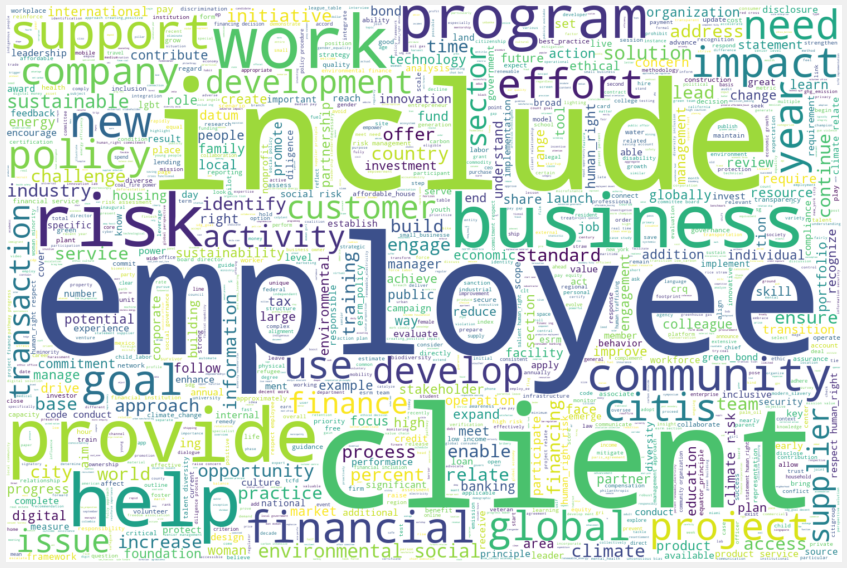

In [26]:
from wordcloud import WordCloud

# aggregate all 7200 records into one large string to run wordcloud on term frequency
large_string = ' '.join(report_sentences_lemma)

# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=1500, 
    height=1000, 
    stopwords=stop_words, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(16,16))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### TFIDF - Unigram and Bigram Analysis

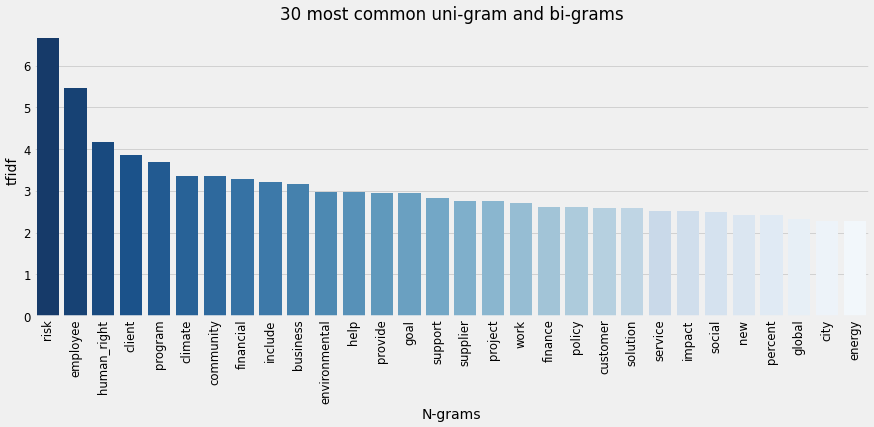

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=10, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(report_sentences_lemma)

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

# Plot top 10 ngrams
plt.figure(figsize=(16, 6))
plt.subplot(title='30 most common uni-gram and bi-grams')
sns.barplot(x_pos, counts, palette='Blues_r')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('N-grams')
plt.ylabel('tfidf')
plt.show()

---


## Topic Modeling and Latent Dirichlet Allocation (LDA)

Evaluaton Metrics
1. **Perplexity**: Captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.  Lower the better.
2. **Coherence Score**: Measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.  Higher the better.

In the analysis, the model with the highest coherence score is selected as the optimal model.

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [29]:
results = []
optimal_score = 0
optimal_model = None

for num_of_topics in tqdm(range(2,15,1)):
    
    result = {}
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_of_topics, 
                                                random_state=42,
                                                update_every=1,
                                                chunksize=5,
                                                passes=20,
                                                alpha='auto',
                                                per_word_topics=True) 

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    if optimal_score < coherence_model_lda.get_coherence():
        optimal_score = coherence_model_lda.get_coherence()
        optimal_model = lda_model

    result['num_of_topics'] = num_of_topics
    result['perplexity'] = lda_model.log_perplexity(corpus)
    result['coherence_score'] = coherence_model_lda.get_coherence()
    
    results.append(result)
    
results = pd.DataFrame(results)  
results.set_index('num_of_topics', inplace=True) 

  0%|          | 0/13 [00:00<?, ?it/s]

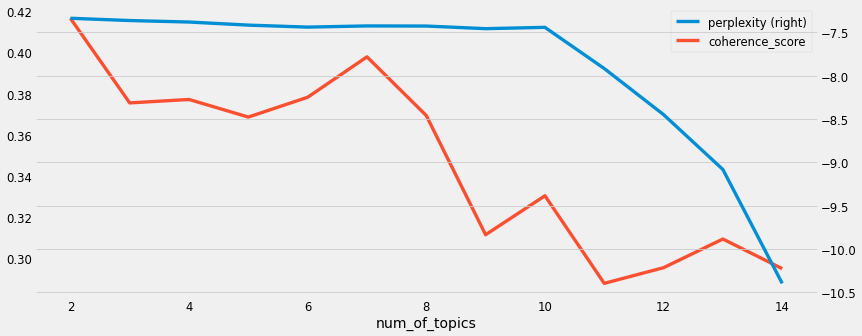

In [30]:
results.plot(secondary_y='perplexity')
plt.show()

In [31]:
results

perplexity  coherence_score
num_of_topics                             
2               -7.339238         0.416640
3               -7.365434         0.375440
4               -7.382657         0.377121
5               -7.418271         0.368551
6               -7.441310         0.378196
7               -7.427526         0.397861
8               -7.428997         0.369281
9               -7.459101         0.311284
10              -7.444017         0.330245
11              -7.918685         0.287617
12              -8.450022         0.295245
13              -9.082548         0.309197
14             -10.395178         0.294773

In [32]:
# Compute Perplexity
print('\nPerplexity of the Optimal Model: ', optimal_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score of the Optimal Model: ', coherence_lda)


Perplexity of the Optimal Model:  -7.339238300615962

Coherence Score of the Optimal Model:  0.4166398567811642


---

## Visualize the topics

In [33]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.106215  0.0       1        1  50.834426
1     -0.106215  0.0       2        1  49.165574, topic_info=              Term        Freq       Total Category  logprob  loglift
365           risk  157.000000  157.000000  Default  30.0000  30.0000
678    human_right  128.000000  128.000000  Default  29.0000  29.0000
177        program  112.000000  112.000000  Default  28.0000  28.0000
710       supplier   71.000000   71.000000  Default  27.0000  27.0000
76   environmental   65.000000   65.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
64     development   33.068018   44.117813   Topic2  -5.6614   0.4217
299      financial   40.291431   74.866527   Topic2  -5.4638   0.0904
110        include   45.937807  124.228246   Topic2  -5.3327  -0.2849
325          learn   29.243214   35.894840   Topic2  -5.7843   0.5050
176        product   29.315256   44.773865   Topic2  -5.7818   0.2865

[142 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         1  0.036595  access
1         2  0.951477  access
400       1  0.902937  action
400       2  0.082085  action
832       1  0.052507     aim
...     ...       ...     ...
236       1  0.371674    work
236       2  0.628987    work
239       1  0.349557    year
239       2  0.649177    year
240       2  0.915128   young

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [34]:
# Print the Keyword in the 10 topics
pprint(optimal_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"risk" + 0.013*"human_right" + 0.013*"citi" + 0.009*"report" + '
  '0.008*"client" + 0.008*"policy" + 0.008*"include" + 0.007*"employee" + '
  '0.007*"supplier" + 0.007*"respect"'),
 (1,
  '0.020*"citi" + 0.016*"employee" + 0.012*"program" + 0.007*"provide" + '
  '0.007*"customer" + 0.007*"work" + 0.006*"help" + 0.006*"business" + '
  '0.006*"new" + 0.006*"percent"')]


---

## Distinguishing the different ESG topics

In [35]:
topic_names = {0: 'support community', 1: 'value employees'}

#     'value employees',
#     'ethical investments',
#     'strong governance',
#     'focus customer',    
#     'green energy',
#     'support community',
#     'code of conduct',
#     'sustainable finance',
#     'company transformation',


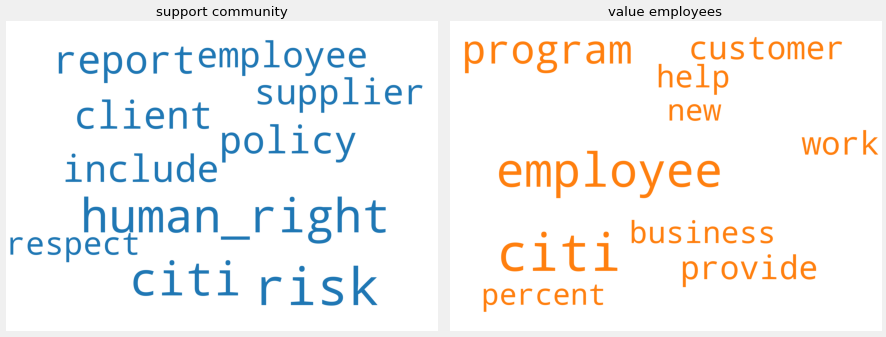

In [36]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Closing Notes
1. This is only a simple analysis that studies the ESG topics in only one ESG report.  This study can be extended to more reports issued by the many companies across different sectors and industries.
2. We can expect the number of topics to increase when more ESG reports are included in the study.
3. Once relevant ESG topics are identified, then we can potentially calculate ESG scores by topics for all companies.  Then we can assess and see whether such ESG score derived through NLP process correlates with the score given by rating agencies downloaded from yahoo finance.